<img src="./imgs/DRRlogo.jpg" width="350" />

# Preparation of DEM raster data sets for use in the CAPRA model

Digital elevation models (DEMs) are arrays of regularly spaced elevation values referenced horizontally either to a Universal Transverse Mercator (UTM) projection or to a geographic coordinate system. The grid cells are spaced at regular intervals along south to north profiles that are ordered from west to east. Digital Elevation Models  are required data inputs in disaster modeling within the framework of CAPRA. A DEM is necessary in the modeling of Primary Hazards e.g., Hurricanes, Volcanoes and the modeling of Secondary Hazards that result from Primary Hazards e.g., Landslide that results from Seismic Activity, or Flooding that results from Hurricanes and Non-Hurricane rain events.

This tutorial will go over how to read DEM data from Google Earth Engine (GEE), how to clip it to your area of interest,  visualiaze and download the data. 

### Learning Objectives

- Learn to download DEM data from GEE
- Clip to area of interest
- Visualize data with Folium

### DEM Resolution

Coarse or low resolution ‘general’ DEMs are used for modeling more regional and large extent events (e.g., ‘volcano’, ‘hurricane’, ‘landslide’). For each of these models one could also be interested in localized events (e.g. localized landslides) or effects, which would require precise high resolution DEMs. Localized models in general depend on more information than regional models. Uncertainty of a DEM and its derivatives is often negligible when compared to the uncertainty of the other parameters. When high quality data for all model required parameters are available it would be of great benefit to increase the effort in deriving more precise and DEM’s at higher resolutions. A ‘detailed’ topographic DEM is currently only used for flood modeling. This model requires a low resolution ‘general’ DEM and a high resolution or ‘detailed’ DEM. Great advances have been made in hydrological surface runoff models and as demonstrated previously the input of DEMs of high horizontal and vertical resolution and accuracy are crucial in determining reliable flow accumulations and therefore potential flood risk. Therefore, referring to data resolution is relative to the process or modeled phenomenon. ‘General‘ refers to regional resolution or large scale, while ‘detailed’ refers to a local high resolution relative to the general DEM resolution. Many sources of DEMs or raw data sources from which DEMs can be derived exist for low or medium resolution products. These sources include readily available DEMs or satellite imagery. Commonly used and readily available DEMs at low or medium resolution include GTOPO30 and SRTM products.

The GTOPO30 is a DEM raster with a low regional resolution (1km) and if it is used in the modeling of an event, it is likely that the event is on a coarse spatial scale of tens, hundreds or even thousands of kilometers in extent.  If the effects of such a large events are to be modeled locally, a higher resolution or ‘detailed’ DEM is required to adequately represent terrain properties that will produce reasonable model output at that scale.  Suitable data sources for the ‘detailed’ higher resolution DEM are ASTER, SRTM, and Stereo Plotting or contour interpolation from aerial photography.  When the ‘general’ DEM is at a medium resolution, as provided by the SRTM data with a resolution of 90m, then the ‘detailed’ DEM again will be at a relatively higher resolution and ASTER data with a resolution of 30m or even higher resolution products as provided by stereoplotting or LiDAR derived products might be suitable.

In [10]:
# Import required modules 

import ee
import requests
import zipfile
import numpy as np

First we will read the SRTM data from GEE and vizualize the global data.

In [16]:
# Initialize GEE
ee.Initialize()

# Import the Image function from the IPython.display module. 
from IPython.display import Image

# Display a thumbnail of global elevation.
dem = ee.Image('USGS/SRTMGL1_003')
Image(url=dem.getThumbUrl({'min': 0, 'max': 3000}))

Now we will learn how to find the elevation of specific locations. In this case, the highest mountain in the Dominical Republic: Pico Duarte. You can use google earth to find the coordinates of your are of interest. 

In [17]:
#  Read SRTM and print the elevation of Pico Duarte.
xy = ee.Geometry.Point([-70.998, 19.023])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Pico Duarte elevation (m):', elev)

Pico Duarte elevation (m): 3080


Now we will zoom into our area of interest in the Dominican Republic by using the Folium library

In [18]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, eeImageObject, visParams, name):
  mapID = ee.Image(eeImageObject).getMapId(visParams)
  folium.raster_layers.TileLayer(
    tiles = "https://earthengine.googleapis.com/map/"+mapID['mapid']+
      "/{z}/{x}/{y}?token="+mapID['token'],
    attr = "Map Data &copy; <a href='https://earthengine.google.com/'>Google Earth Engine</a>",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
visParams = {'min':0, 'max':3000, 'palette':['225ea8','41b6c4','a1dab4','ffffcc']}

# Create a folium map object.
myMap = folium.Map(location=[19.023, -70.998], zoom_start=5, height=500)

# Add the elevation model to the map object.
myMap.add_ee_layer(dem, visParams, 'DEM')

# Add a layer control panel to the map.
myMap.add_child(folium.LayerControl())

# Display the map.
display(myMap)

To download the DEM to our local drive we need to determine the four corners of our are of interest. You can do this in GEE. We can use the pp.print command to look into the metadta of the DEM data. 

In [20]:
import pprint

# Configure the pretty printing output 
pp = pprint.PrettyPrinter(depth=4)

# Set the boundaries and 
bounds = [-70.81, 19.76, -69.27, 18.44] ## sample land / sea bounds
area = ee.Geometry.Rectangle(-70.81, 19.76, -69.27, 18.44)
img = ee.Image('USGS/SRTMGL1_003').clip(area)
pp.pprint(img.getInfo())

{'bands': [{'crs': 'EPSG:4326',
            'crs_transform': [0.0002777777777777778,
                              0.0,
                              -180.0001388888889,
                              0.0,
                              -0.0002777777777777778,
                              60.00013888888889],
            'data_type': {'max': 32767,
                          'min': -32768,
                          'precision': 'int',
                          'type': 'PixelType'},
            'dimensions': [5545, 4759],
            'id': 'elevation',
            'origin': [393084, 144858]}],
 'id': 'USGS/SRTMGL1_003',
 'properties': {'date_range': [950227200000.0, 951177600000.0],
                'description': '<p>The Shuttle Radar Topography Mission (SRTM, '
                               'see <a '
                               'href="http://onlinelibrary.wiley.com/doi/10.1029/2005RG000183/full">Farr\n'
                               'et al. 2007</a>)\n'
                              

The DEM can be exported to your Google Drive account using the "ee.batch.Export.image.toDrive" command 

In [21]:
task = ee.batch.Export.image.toDrive(
        image = img,
        description = "srtm_DR",
        folder = "pruebatest",
        maxPixels = 100000000,
        fileFormat = 'GeoTIFF',
        scale = 90)
task.start()
print("Export to drive started!")

Export to drive started!


It can also be exported to GEE as an Asset

In [23]:
task = ee.batch.Export.image.toAsset(
        image = img,
        description = "srtm_DR",
        assetId = 'users/ximenamesa/' + "DEM",
        maxPixels=100000000,
        fileFormat = 'GeoTIFF',
        scale = 90)
task.start()
print("Export task 2 started!")

Export task 2 started!


Copy the .tif file from your Google Drive account to the source folder for this code. We can use GDAL in order to open the file and read it in as a 2D array. Additionally, it is important to note that our DEM file has NaN values which will later cause Matplotlib to fail. Therefore, we'll also mask these values out so that Matplotlib will be unaware of them.

In [29]:
from osgeo import gdal
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import elevation 

In [27]:
filename = "srtm_DR.tif"
gdal_data = gdal.Open(filename)
gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# convert to a numpy array
data_array = gdal_data.ReadAsArray().astype(np.float)
data_array

# replace missing values if necessary
if np.any(data_array == nodataval):
    data_array[data_array == nodataval] = np.nan

## Visualize Data with Matplotlib

Now that we've read our data in, we're ready to visualize the elevation using contour lines within Matplotlib (Note: We will be re-reading in the data again here due to NaN values).

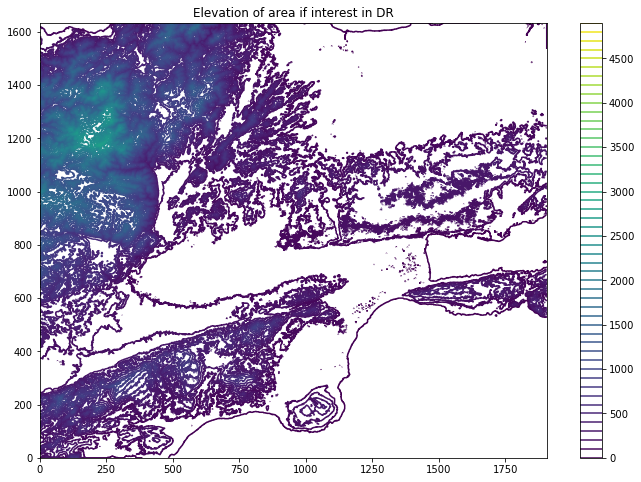

In [31]:
#Plot out data with Matplotlib's 'contour'
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contour(data_array, cmap = "viridis", 
            levels = list(range(0, 5000, 100)))
plt.title("Elevation of area if interest in DR")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

We just used the 'contour' module to plot our data. Let's do it again but with 'contourf' to see filled contours.

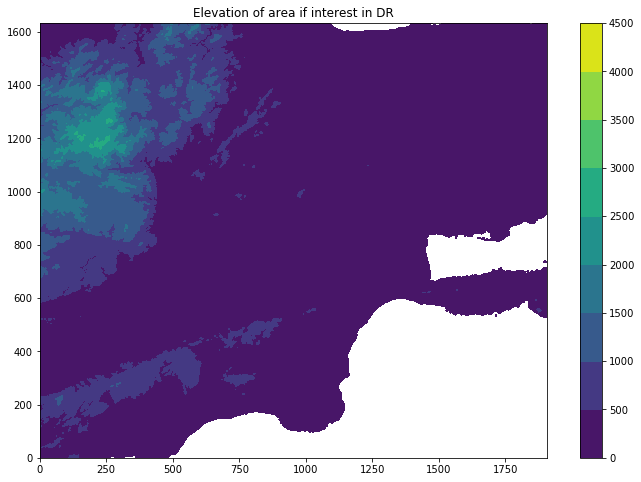

In [34]:
#Plot our data with Matplotlib's 'contourf'
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(data_array, cmap = "viridis", 
            levels = list(range(0, 5000, 500)))
plt.title("Elevation of area if interest in DR")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()